In [280]:
from dotenv import load_dotenv
import os

load_dotenv(verbose=True)
key = os.getenv('OPENAI_API_KEY')

In [281]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [282]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages

In [283]:
from langgraph.graph import StateGraph 
from langgraph.graph import START, END

In [284]:
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_teddynote.tools.tavily import TavilySearch

In [285]:
from langchain_core.messages import HumanMessage
from langchain_core.messages import AIMessage, ToolMessage

In [286]:
from langchain_openai import ChatOpenAI

In [287]:
from langchain_teddynote.graphs import visualize_graph

In [288]:
######### 1. 상태 정의 #########

# 상태 정의
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [289]:
######### 2. 도구 정의 및 바인딩 #########

tool = TavilySearch(max_results=1)
tools = [tool]

In [290]:
######### 3. LLM을 도구와 결합 #########

llm = ChatOpenAI(
    api_key=key, 
    model_name='gpt-4o-mini',
    temperature=0.1
)

llm_with_tools = llm.bind_tools(tools)

In [291]:
def chatbot(state: State):
    print(f'=='*50)
    print('===== chatbot() 함수 시작 =====')
    print(f"chatbot() 으로 넘어온 메시지 :")
    print(state['messages'])
    print(f"메시지 개수 : {len(state['messages'])}")
    print()

    answer = llm_with_tools.invoke(state['messages'])

    print(f'[도구 사용 LLM 실행 결과 content]: {answer.content}')
    print(f'[도구 사용 LLM 실행 결과 answer]: {answer}')
    print(f'[도구 사용 LLM 실행 결과 additional_kwargs]: {answer.additional_kwargs}')

    print('===== chatbot() 함수  끝 =====')
    print(f'=='*50)
    print()

    return {'messages': [answer]}

In [292]:
# 테스트
question = '대구 맛있는 고기집에 대해서 알려줘'

state = State(messages=[('user', question)])
chatbot(state)

===== chatbot() 함수 시작 =====
chatbot() 으로 넘어온 메시지 :
[('user', '대구 맛있는 고기집에 대해서 알려줘')]
메시지 개수 : 1

[도구 사용 LLM 실행 결과 content]: 
[도구 사용 LLM 실행 결과 answer]: content='' additional_kwargs={'tool_calls': [{'id': 'call_Hk3DGawP3cvWFE72RCp6zVWW', 'function': {'arguments': '{"query":"대구 맛있는 고기집"}', 'name': 'tavily_web_search'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 24, 'prompt_tokens': 102, 'total_tokens': 126, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_3267753c5d', 'finish_reason': 'tool_calls', 'logprobs': None} id='run-528fb324-895b-4d72-985f-e98bda7728a9-0' tool_calls=[{'name': 'tavily_web_search', 'args': {'query': '대구 맛있는 고기집'}, 'id': 'call_Hk3DGawP3cvWFE72RCp6zVWW', 'type': 'tool_call'}] usage_metadata={'input

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_Hk3DGawP3cvWFE72RCp6zVWW', 'function': {'arguments': '{"query":"대구 맛있는 고기집"}', 'name': 'tavily_web_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 24, 'prompt_tokens': 102, 'total_tokens': 126, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_3267753c5d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-528fb324-895b-4d72-985f-e98bda7728a9-0', tool_calls=[{'name': 'tavily_web_search', 'args': {'query': '대구 맛있는 고기집'}, 'id': 'call_Hk3DGawP3cvWFE72RCp6zVWW', 'type': 'tool_call'}], usage_metadata={'input_tokens': 102, 'output_tokens': 24, 'total_tokens': 126, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_tok

In [293]:
graph_builder = StateGraph(State)               # 그래프 생성

In [294]:
graph_builder.add_node('chatbot', chatbot)      # 챗봇 노드 추가

In [295]:
tool_node = ToolNode(tools=[tool])              # 도구 노드 생성

In [296]:
graph_builder.add_node('tools', tool_node)      # 도구 노드 추가

In [297]:
graph_builder.add_conditional_edges(            # 조건부 엣지
    'chatbot',
    tools_condition
)

In [298]:
######### 5. 엣지 추가 #########

graph_builder.add_edge('tools', 'chatbot')      # tools 에서 chatbot 으로

In [299]:
graph_builder.add_edge(START, 'chatbot')        # START 에서 chatbot 으로

In [300]:
graph_builder.add_edge('chatbot', END)          # chatbot 에서 END 로

In [301]:
graph = graph_builder.compile(checkpointer=memory)

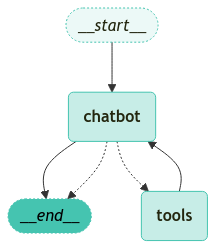

In [302]:
visualize_graph(graph)

In [303]:
from langchain_teddynote.graphs import generate_random_hash
from langchain_core.runnables import RunnableConfig
import json

thread_id = generate_random_hash()
print(f"thread_id: {thread_id}")

# config 설정
config = RunnableConfig(
    recursion_limit=10,             
    configurable={"thread_id": thread_id},  
    tags=["data-tag"],                  
)

question = '대구 맛집을 알려줘?'

state = State(messages=[('user', question)])

i = 1

for event in graph.stream({"messages": [("user", question)]}, config=config):
    print()
    print('===== 여기서 시작 =====')
    print(f'[event] 바깥 for 시작 {i}')
    print()

    for k, value in event.items():
        print(f'실행한 노드 이름: {k}')
        print()

        if isinstance(value['messages'][-1], HumanMessage):
            print('==================== HumanMessage ========================')
            print(f"[해당 노드 값] value : \n{value['messages'][-1]}")
            # print(f"[해당 노드 값] content: {value['messages'][-1].content}")
            # print(f"additional_kwargs: {value['messages'][-1].additional_kwargs}")
            print('==================== END HumanMessage ====================')
            print()
        elif isinstance(value['messages'][-1], AIMessage):
            print('==================== AIMessage ========================')
            # print(f"[해당 노드 값] value : \n{value['messages'][-1]}")
            print(f"[해당 노드 값] value content: {value['messages'][-1].content}")
            # print(f"addtional_kwargs: {value['messages'][-1].additional_kwargs}")

            if 'tool_calls' in value['messages'][-1].additional_kwargs:
                # print(f"additional_kwargs tool_calls: {value['messages'][-1].additional_kwargs['tool_calls']}")
                tool_calls = value['messages'][-1].additional_kwargs['tool_calls']

                for call in tool_calls:
                    if 'function' in call:
                        arguments = json.loads(call['function']['arguments'])
                        name = call['function']['name']

                        print(f"도구 이름 : {name}")
                        print(f"Arguments: {arguments}")
            else:
                print("additional_kwargs tool_calls: None")
            print('==================== END AIMessage ====================')    

        elif isinstance(value['messages'][-1], ToolMessage):
            print('==================== ToolMessage ========================')
            # print(f"[해당 노드 값] value : \n{value['messages'][-1]}")
            content = json.loads(value['messages'][-1].content)

            if content and isinstance(content, list) and len(content) > 0:
                print(f"[해당 노드 값] 제목: {content[0].get('title', 'No title')}")
                print(f"[해당 노드 값] URL: {content[0].get('url', 'No URL')}")
                print(f"[해당 노드 값] 내용: {content[0].get('content', 'No URL')}")
            else:
                print("No content or invalid content format in ToolMessage")

            print('==================== END ToolMessage ====================')   

        print()
        
    print('바깥 for 끝')
    i=i+1
    
    print('===== 여기서 끝 =====') 
    print()
print(f'전체 반복문 {i}번 실행')    

thread_id: 9211c5
===== chatbot() 함수 시작 =====
chatbot() 으로 넘어온 메시지 :
[HumanMessage(content='대구 맛집을 알려줘?', additional_kwargs={}, response_metadata={}, id='f3bf6d78-a91e-48ff-a253-3f878f656e73')]
메시지 개수 : 1

[도구 사용 LLM 실행 결과 content]: 
[도구 사용 LLM 실행 결과 answer]: content='' additional_kwargs={'tool_calls': [{'id': 'call_0Iwa29atx7zZo1DbfsjHeRVY', 'function': {'arguments': '{"query":"대구 맛집"}', 'name': 'tavily_web_search'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 99, 'total_tokens': 120, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_3267753c5d', 'finish_reason': 'tool_calls', 'logprobs': None} id='run-6b2e11c3-5a4d-4aab-b31d-e4e4165d15d1-0' tool_calls=[{'name': 'tavily_web_search', 'args': {'que

In [304]:
config = RunnableConfig(
    recursion_limit=10, 
    configurable={'thread_id': '1'}
)

question = ('`소프트웨어놀이터`에서 코딩강의를 하고 있는 이인환입니다.')

for event in graph.stream({"messages": [("user", question)]}, config=config):
    for value in event.values():
        value["messages"][-1].pretty_print()

===== chatbot() 함수 시작 =====
chatbot() 으로 넘어온 메시지 :
[HumanMessage(content='`소프트웨어놀이터`에서 코딩강의를 하고 있는 이인환입니다.', additional_kwargs={}, response_metadata={}, id='451360d1-dfa7-4c90-a7d8-7556a637a165')]
메시지 개수 : 1

[도구 사용 LLM 실행 결과 content]: 안녕하세요, 이인환님! 소프트웨어놀이터에서 코딩 강의를 하고 계시다니 멋지네요. 어떤 주제에 대해 강의를 하고 계신가요? 또는 도움이 필요하신 부분이 있으신가요?
[도구 사용 LLM 실행 결과 answer]: content='안녕하세요, 이인환님! 소프트웨어놀이터에서 코딩 강의를 하고 계시다니 멋지네요. 어떤 주제에 대해 강의를 하고 계신가요? 또는 도움이 필요하신 부분이 있으신가요?' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 55, 'prompt_tokens': 110, 'total_tokens': 165, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_3267753c5d', 'finish_reason': 'stop', 'logprobs': None} id='run-9362f2e1-6200-45ed-881b-0af56aa5cfe4-0' usage_metadata={'input_tokens':

In [305]:
config = RunnableConfig(
    recursion_limit=10, 
    configurable={'thread_id': '1'}
)

snapshot = graph.get_state(config=config)

In [306]:
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='`소프트웨어놀이터`에서 코딩강의를 하고 있는 이인환입니다.', additional_kwargs={}, response_metadata={}, id='451360d1-dfa7-4c90-a7d8-7556a637a165'), AIMessage(content='안녕하세요, 이인환님! 소프트웨어놀이터에서 코딩 강의를 하고 계시다니 멋지네요. 어떤 주제에 대해 강의를 하고 계신가요? 또는 도움이 필요하신 부분이 있으신가요?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 55, 'prompt_tokens': 110, 'total_tokens': 165, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_3267753c5d', 'finish_reason': 'stop', 'logprobs': None}, id='run-9362f2e1-6200-45ed-881b-0af56aa5cfe4-0', usage_metadata={'input_tokens': 110, 'output_tokens': 55, 'total_tokens': 165, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]},

In [307]:
snapshot.config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f00309a-5bb6-61bd-8001-af6d11f9e347'}}

In [308]:
snapshot.values

{'messages': [HumanMessage(content='`소프트웨어놀이터`에서 코딩강의를 하고 있는 이인환입니다.', additional_kwargs={}, response_metadata={}, id='451360d1-dfa7-4c90-a7d8-7556a637a165'),
  AIMessage(content='안녕하세요, 이인환님! 소프트웨어놀이터에서 코딩 강의를 하고 계시다니 멋지네요. 어떤 주제에 대해 강의를 하고 계신가요? 또는 도움이 필요하신 부분이 있으신가요?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 55, 'prompt_tokens': 110, 'total_tokens': 165, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_3267753c5d', 'finish_reason': 'stop', 'logprobs': None}, id='run-9362f2e1-6200-45ed-881b-0af56aa5cfe4-0', usage_metadata={'input_tokens': 110, 'output_tokens': 55, 'total_tokens': 165, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}

In [309]:
snapshot.next

()

In [310]:
snapshot.metadata

{'source': 'loop',
 'writes': {'chatbot': {'messages': [AIMessage(content='안녕하세요, 이인환님! 소프트웨어놀이터에서 코딩 강의를 하고 계시다니 멋지네요. 어떤 주제에 대해 강의를 하고 계신가요? 또는 도움이 필요하신 부분이 있으신가요?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 55, 'prompt_tokens': 110, 'total_tokens': 165, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_3267753c5d', 'finish_reason': 'stop', 'logprobs': None}, id='run-9362f2e1-6200-45ed-881b-0af56aa5cfe4-0', usage_metadata={'input_tokens': 110, 'output_tokens': 55, 'total_tokens': 165, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}},
 'thread_id': '1',
 'step': 1,
 'parents': {}}

In [311]:
snapshot.metadata['writes']['chatbot']['messages'][0]

AIMessage(content='안녕하세요, 이인환님! 소프트웨어놀이터에서 코딩 강의를 하고 계시다니 멋지네요. 어떤 주제에 대해 강의를 하고 계신가요? 또는 도움이 필요하신 부분이 있으신가요?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 55, 'prompt_tokens': 110, 'total_tokens': 165, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_3267753c5d', 'finish_reason': 'stop', 'logprobs': None}, id='run-9362f2e1-6200-45ed-881b-0af56aa5cfe4-0', usage_metadata={'input_tokens': 110, 'output_tokens': 55, 'total_tokens': 165, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [312]:
from langchain_teddynote.messages import display_message_tree

display_message_tree(snapshot.metadata)

    source: "loop"
    writes:
        chatbot:
            messages:
                index [0]
                    content: "안녕하세요, 이인환님! 소프트웨어놀이터에서 코딩 강의를 하고 계시다니 멋지네요. 어떤 주제에 대해 강의를 하고 계신가요? 또는 도움이 필요하신 부분이 있으신가요?"
                    additional_kwargs: {"refusal": None}
                    response_metadata:
                        token_usage:
                            completion_tokens: 55
                            prompt_tokens: 110
                            total_tokens: 165
                            completion_tokens_details: {"accepted_prediction_tokens": 0, "audio_tokens": 0, "reasoning_tokens": 0, "rejected_prediction_tokens": 0}
                            prompt_tokens_details: {"audio_tokens": 0, "cached_tokens": 0}
                        model_name: "gpt-4o-mini-2024-07-18"
                        system_fingerprint: "fp_3267753c5d"
                        finish_reason: "stop"
                        logprobs: None
                    type: "ai"
              